# In this tutorial, we will learn about TorchData


![Photo by Scott Webb from Pexels](https://images.pexels.com/photos/1029635/pexels-photo-1029635.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2)

PyTorch 1.11 came with a new libray called `TorchData`. It provides common data loading primitives for easily constructing flexible and performant data pipelines. TorchData promotes composable data loading for code reusablity with `DataPipes`.

`DataPipes` is the building block of TorchData and works out of the box with PyTorch `DataLoader`. It can be chained to form a data pipeline where data will be transformed from each `DataPipe`.

For example if we have image dataset in a folder with a CSV mapping of classes and we want to create a DataLoader that returns batch of image Tensor and labels.

For this we need we do the following steps:

1. Read and Parse the CSV
2. 
    a. Get image filepath
    b. Decode label
3. Read Image
4. Convert Image to Tensor
5. Return image Tensor and Label index

These steps can be a chained DataPipe where the initial data will flow from the first step to the very last applying transformations in each step.

Now, lets see how to do the same with TorchData code.

In [3]:
!pip install torchdata -q

In [1]:
import torch
from torchdata.datapipes.iter import (
    FileOpener,
    Filter,
    FileLister, Filter, 
)


from PIL import Image
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_tensor

We will use CIFAR-10 dataset which has the same structure as we discussed.

From TorchData docs:

> We have implemented over 50 DataPipes that provide different core functionalities, such as opening files, parsing texts, transforming samples, caching, shuffling, and batching. For users who are interested in connecting to cloud providers (such as Google Drive or AWS S3), the fsspec and iopath DataPipes will allow you to do so. The documentation provides detailed explanations and usage examples of each IterDataPipe and MapDataPipe.

Basically, TorchData has already implemented 50 DataPipes which you can use directly. Here we will use use `FileOpener` and `parse_csv` to read the csv data.

In [10]:
ROOT = "/Users/aniket/datasets/cifar-10/train"

csv_dp = FileLister(f"{ROOT}/../trainLabels.csv")
csv_dp = FileOpener(csv_dp)
csv_dp = csv_dp.parse_csv()

for i, e in enumerate(csv_dp):
    if i>10: break
    print(e)

['id', 'label']
['1', 'frog']
['2', 'truck']
['3', 'truck']
['4', 'deer']
['5', 'automobile']
['6', 'automobile']
['7', 'bird']
['8', 'horse']
['9', 'ship']
['10', 'cat']


We don't need the header of csv in our datapipe (`[id, label]`), so we will use the inbuilt `Filter` DataPipe to remove it.

In [13]:
csv_dp = Filter(csv_dp, lambda x: x[1]!="label")
labels = {e: i for i, e in enumerate(set([e[1] for e in csv_dp]))}

for i, e in enumerate(csv_dp):
    if i>4: break
    print(e)

['1', 'frog']
['2', 'truck']
['3', 'truck']
['4', 'deer']
['5', 'automobile']


Now, we have a DataPipe `csv_dp` which flows `file id` and `label`. We need to conver the file id into filepath and label in label index.

We can map functions to the DataPipe and even form a chain of mapping to apply transformations.

In [56]:
def get_filename(data):    
    idx, label = data
    return f"{ROOT}/{idx}.png", label

dp = csv_dp.map(get_filename)
for i, e in enumerate(dp):
    if i>4: break
    print(e)

('/Users/aniket/datasets/cifar-10/train/1.png', 'frog')
('/Users/aniket/datasets/cifar-10/train/2.png', 'truck')
('/Users/aniket/datasets/cifar-10/train/3.png', 'truck')
('/Users/aniket/datasets/cifar-10/train/4.png', 'deer')
('/Users/aniket/datasets/cifar-10/train/5.png', 'automobile')


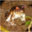

frog


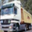

truck


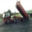

truck


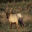

deer


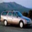

automobile


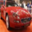

automobile


In [57]:
from IPython.display import display

def load_image(data):
    file, label = data
    return Image.open(file), label

dp = dp.map(load_image)

for i, e in enumerate(dp):
    display(e[0])
    print(e[1])
    if i>=5: break

Finally we map the datapipe to process image to Tensor and label to index.

In [58]:
def process(data):
    img, label = data
    return to_tensor(img), labels[label]

dp = dp.map(process)

If you have come this far then I have a bonus for you. Train an image classifier using DataPipe and PyTorch Lightning Flash ⚡️

Flash expects the dataloader to be in form of a dictionary with keys `input` and `target` where input will contain our image tensor and target will be the label index.

In [59]:
dp = dp.map(lambda x: {"input": x[0], "target": x[1]})

As we discussed that `DataPipes` are fully compatible with DataLoader so this is how you convert a DataPipe to DataLoader.

In [65]:
dl = DataLoader(
        dp,
        batch_size=32,
        shuffle=True,
    )

Training an Image Classifier with Flash is super easy. Flash provides Deep Learning tasks based APIs that you can use to train your model. Currently, our task is image classification so let's import the ImageClassifier and build our model.

In [66]:
from flash.image import ImageClassifier
import flash

In [67]:
model = ImageClassifier(num_classes=len(labels), backbone="efficientnet_b0", pretrained=False)

Using 'efficientnet_b0' provided by rwightman/pytorch-image-models (https://github.com/rwightman/pytorch-image-models).


In [68]:
# Create the trainer and finetune the model
trainer = flash.Trainer(max_epochs=3)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, dl)


  | Name          | Type           | Params
-------------------------------------------------
0 | train_metrics | ModuleDict     | 0     
1 | val_metrics   | ModuleDict     | 0     
2 | test_metrics  | ModuleDict     | 0     
3 | adapter       | DefaultAdapter | 4.0 M 
-------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.081    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]